# Measuring BMI in OpenSAFELY-TPP
This short report describes how BMI can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [1]:
from IPython.display import display, Markdown
from lib import *

In [2]:
### CONFIGURE OPTIONS HERE ###

# Import file
input_path = '../output/data/input_processed.feather'

# Definitions
definitions = ['derived_bmi', 'computed_bmi', 'recorded_bmi']

# Other variables to include
other_vars = ['height','weight']

# Dates
date_min = '2019-01-01'
date_max = '2019-12-31'
time_delta = 'M'

# Min/max range
min_range = 4
max_range = 200

# Null value – 0 or NA
null = 0

# Covariates
demographic_covariates = ['age_band', 'sex', 'ethnicity', 'region', 'imd']
clinical_covariates = ['dementia', 'diabetes', 'hypertension', 'learning_disability']

In [3]:
df_clean = import_clean(input_path, definitions, other_vars, demographic_covariates, clinical_covariates, null, dates=True)

## Methods
 
We define three variable phenotypes: computed, recorded, and derived BMI. 
* Computed BMI refers to BMI calculated from height and weight measurements. 
* Recorded BMI refers to coded events of BMI. 
* Derived BMI refers to the canonical definition used in the OpenSAFELY backend using the `most_recent_bmi()` function, which returns patients' most recent BMI (in the defined period) either computed from weight and height measurements or, where they are not availble, from recorded BMI values.

To evaluate how well each of these phenotypes are populated, we count the number of patients with each phenotype, number of patients missing each phenotype, and number of patients with multiple phenotypes. We also examine the plausibility of each phenotype by looking at the distribution of measurements and counting values out of the expected range. To evaluate how frequently the BMI phenotypes are recorded, we track the number of new measurements recorded over time and compute the average time between updates.

For each of the checks above, we look at the whole population and across each of the following demographic and clinical subgroups to detect any inequalities.

Demographic covariates:
* Age band 
* Sex
* Ethnicity 
* Region
* IMD

Clinical covariates:
* Dementia
* Diabetes
* Hypertension
* Learning disability

## Results

### Count of Patients

In [4]:
patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates)

derived_bmi_filled  \
group               subgroup                                       
population          N                                     1000.0   
                    with records                          1000.0   
age_band            0-19                                   125.0   
                    20-29                                  125.0   
                    30-39                                  125.0   
                    40-49                                  130.0   
                    50-59                                  125.0   
                    60-69                                  120.0   
                    70-79                                  125.0   
                    80+                                    130.0   
sex                 F                                      480.0   
                    M                                      520.0   
ethnicity           1                                      495.0   
                    2                                      230.0   
                    3                                      140.0   
                    4                                       60.0   
                    5                                       45.0   
                    6                                       15.0   
                    7                                        5.0   
                    8                                       10.0   
region              East Midlands                           70.0   
                    East of England                         80.0   
                    London                                 115.0   
                    North East                              55.0   
                    North West                              85.0   
                    South East                             120.0   
                    West Midlands                           60.0   
                    Yorkshire and the Humber                70.0   
imd                 100                                    185.0   
                    200                                    185.0   
                    300                                    210.0   
                    400                                    220.0   
                    500                                    195.0   
dementia            False                                  990.0   
                    True                                    10.0   
diabetes            False                                  990.0   
                    True                                    10.0   
hypertension        False                                  990.0   
                    True                                    10.0   
learning_disability False                                  990.0   
                    True                                    10.0   

                                              derived_bmi_pct  \
group               subgroup                                    
population          N                                   100.0   
                    with records                        100.0   
age_band            0-19                                 12.5   
                    20-29                                12.5   
                    30-39                                12.5   
                    40-49                                13.0   
                    50-59                                12.5   
                    60-69                                12.0   
                    70-79                                12.5   
                    80+                                  13.0   
sex                 F                                    48.0   
                    M                                    52.0   
ethnicity           1                                    49.5   
                    2                                    23.0   
                    3                                    14.0   
                

### Count of Missings

In [5]:
patient_counts(df_clean, definitions, demographic_covariates, clinical_covariates, missing=True)

derived_bmi_missing  \
group               subgroup                                       
population          N                                       1000   
                    missing records                            -   
age_band            0-19                                       -   
                    20-29                                      -   
                    30-39                                      -   
                    40-49                                      -   
                    50-59                                      -   
                    60-69                                      -   
                    70-79                                      -   
                    80+                                        -   
sex                 F                                          -   
                    M                                          -   
ethnicity           1                                          -   
                    2                                          -   
                    3                                          -   
                    4                                          -   
                    5                                          -   
                    6                                          -   
                    7                                          -   
                    8                                          -   
region              East Midlands                              -   
                    East of England                            -   
                    London                                     -   
                    North East                                 -   
                    North West                                 -   
                    South East                                 -   
                    West Midlands                              -   
                    Yorkshire and the Humber                   -   
imd                 100                                        -   
                    200                                        -   
                    300                                        -   
                    400                                        -   
                    500                                        -   
dementia            False                                      -   
                    True                                       -   
diabetes            False                                      -   
                    True                                       -   
hypertension        False                                      -   
                    True                                       -   
learning_disability False                                      -   
                    True                                       -   

                                             derived_bmi_pct  \
group               subgroup                                   
population          N                                    100   
                    missing records                        -   
age_band            0-19                                   -   
                    20-29                                  -   
                    30-39                                  -   
                    40-49                                  -   
                    50-59                                  -   
                    60-69                                  -   
                    70-79                                  -   
                    80+                                    -   
sex                 F                                      -   
                    M                                      -   
ethnicity           1                                      -   
                    2                                      -   
                    3                                      -   
                    4           

### Overlapping Definitions

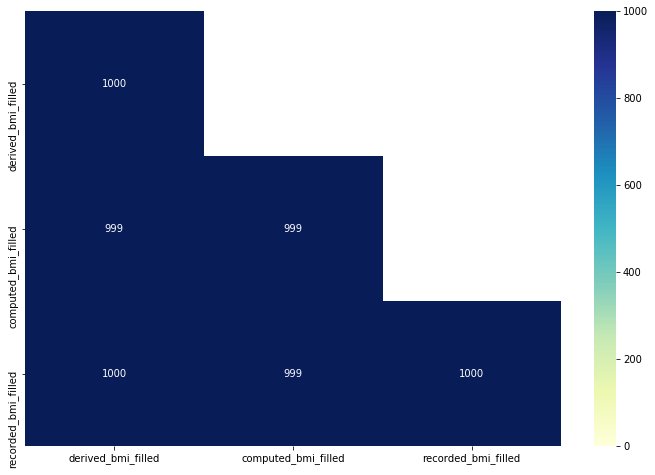

In [6]:
display_heatmap(df_clean, definitions)

### Number of Patients Over Time

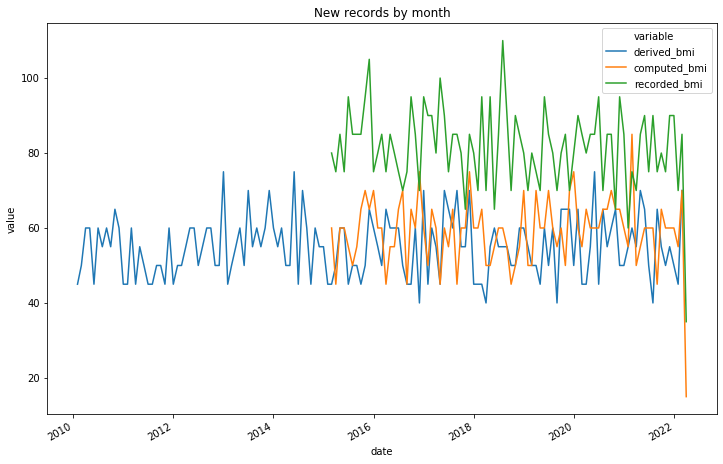

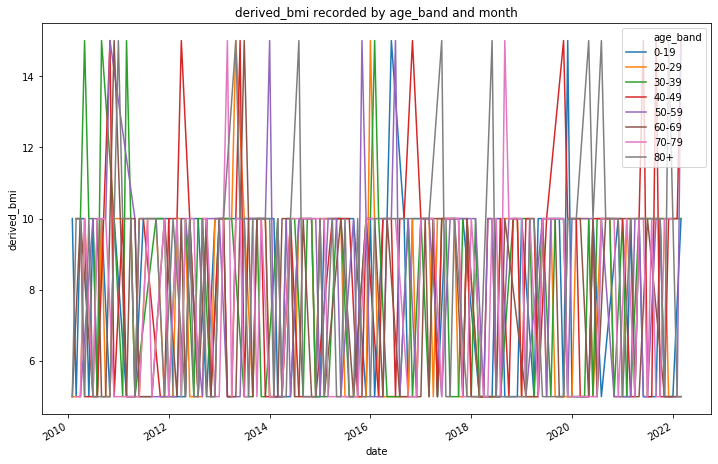

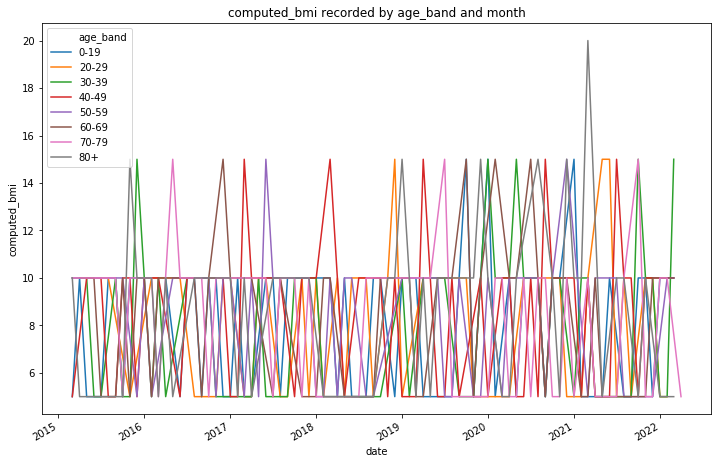

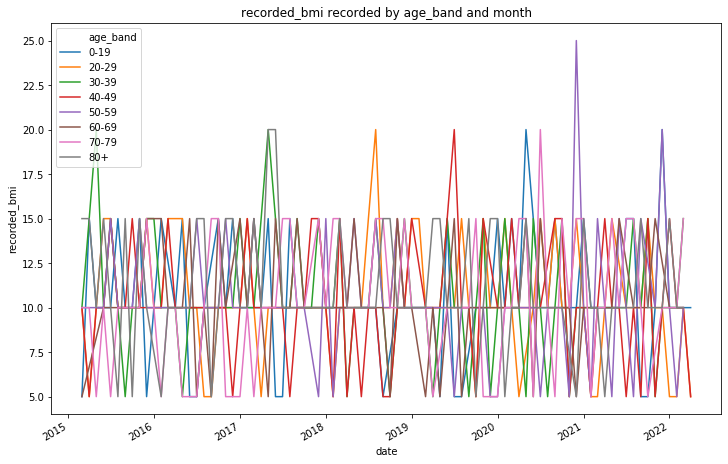

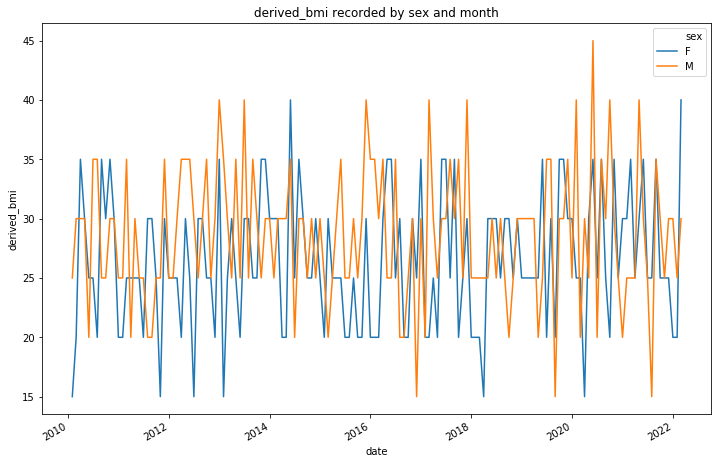

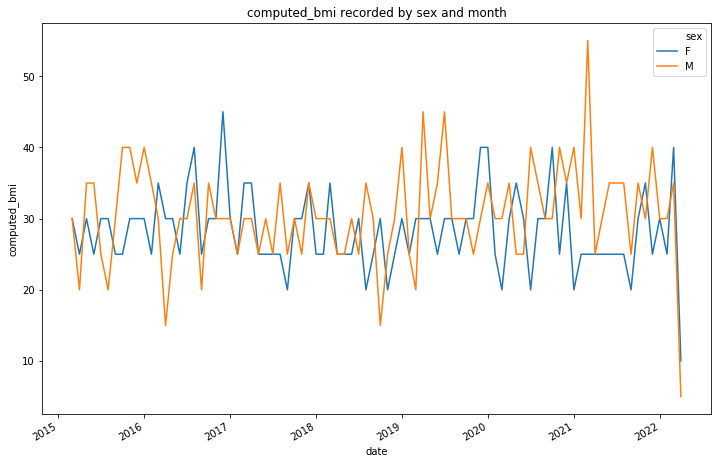

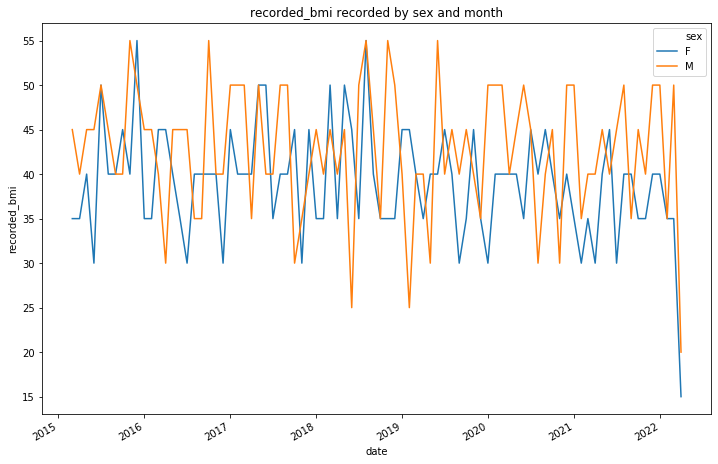

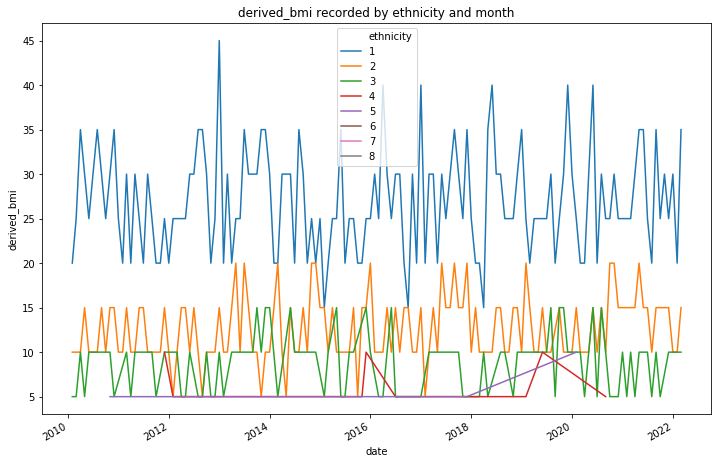

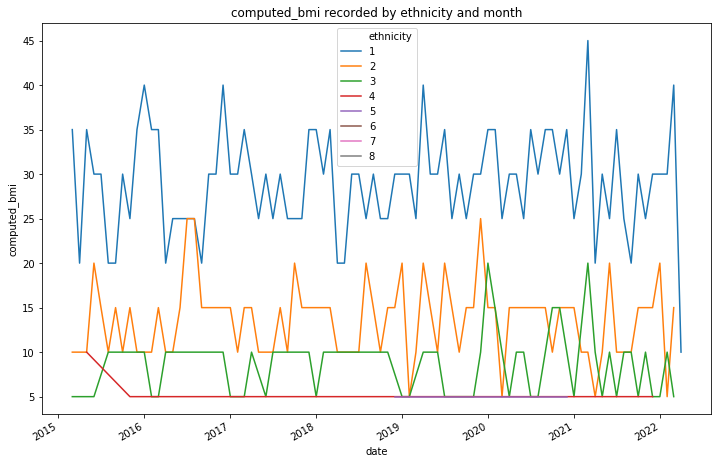

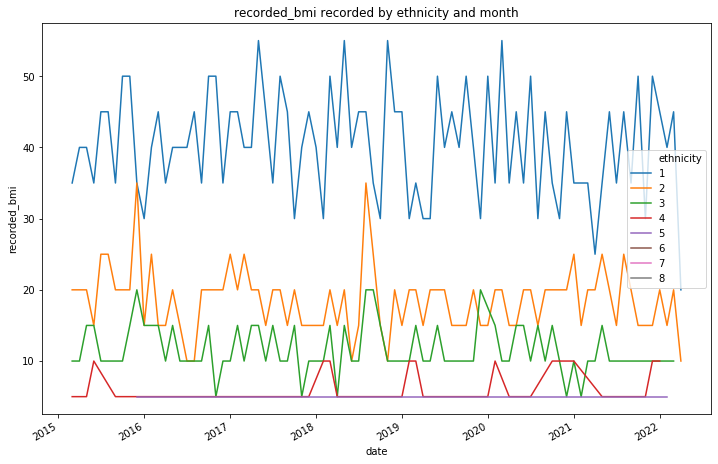

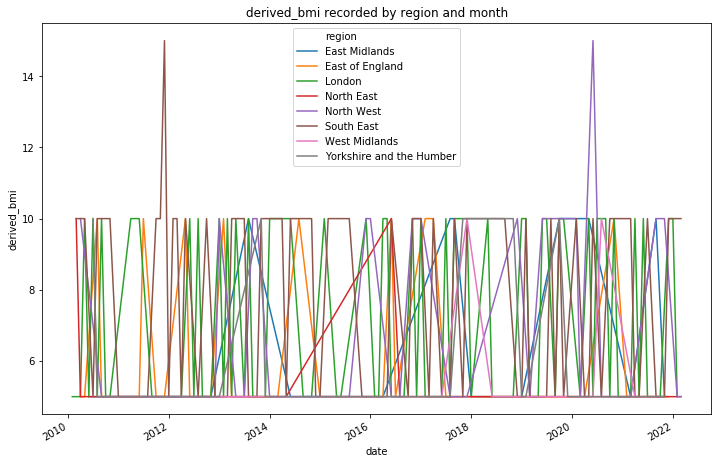

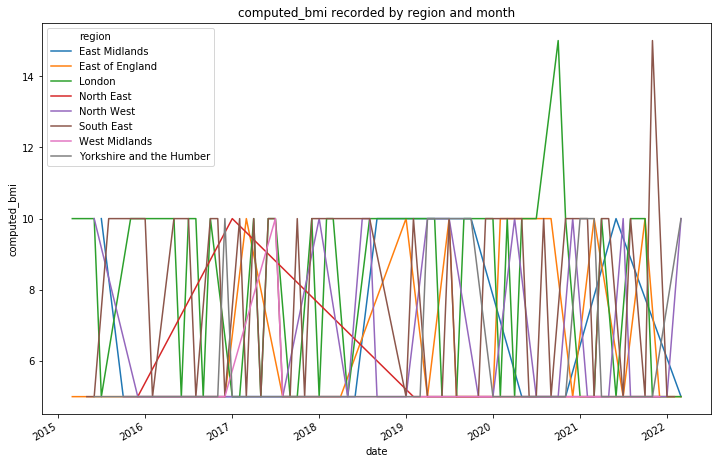

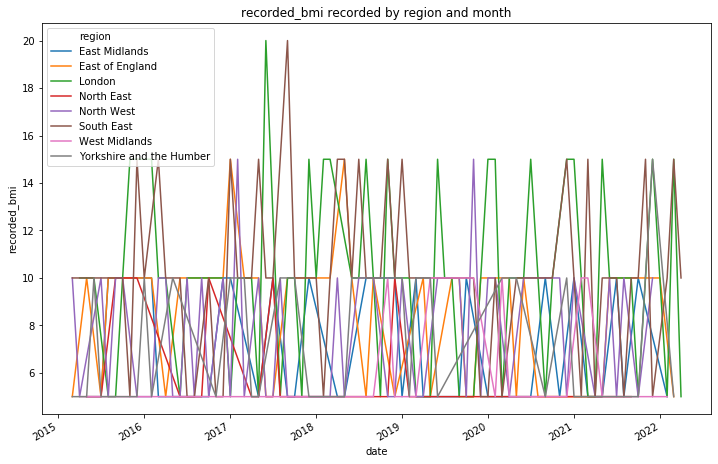

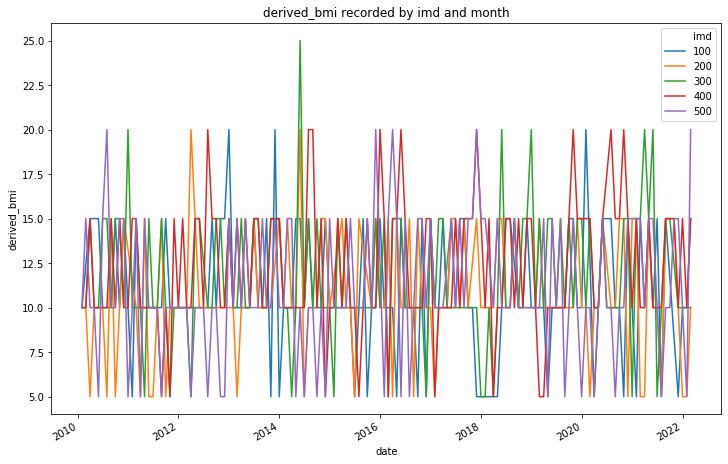

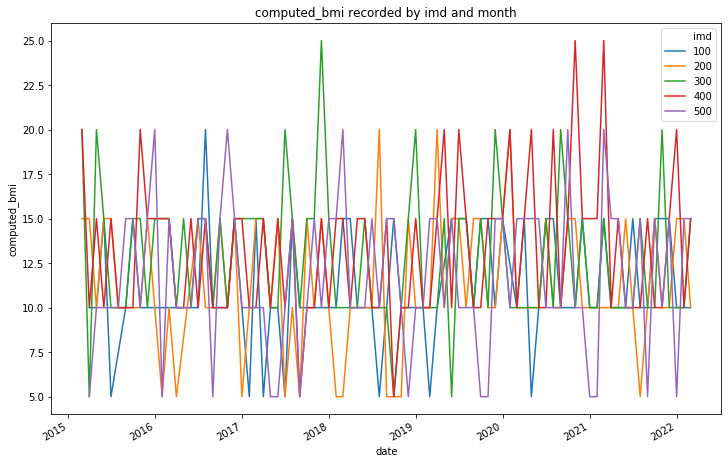

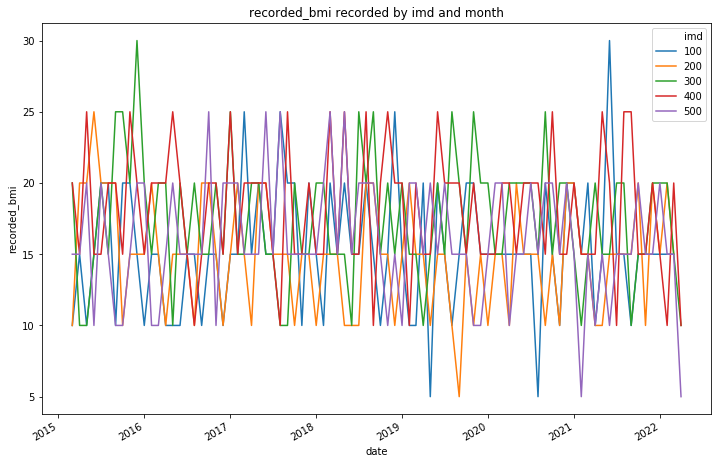

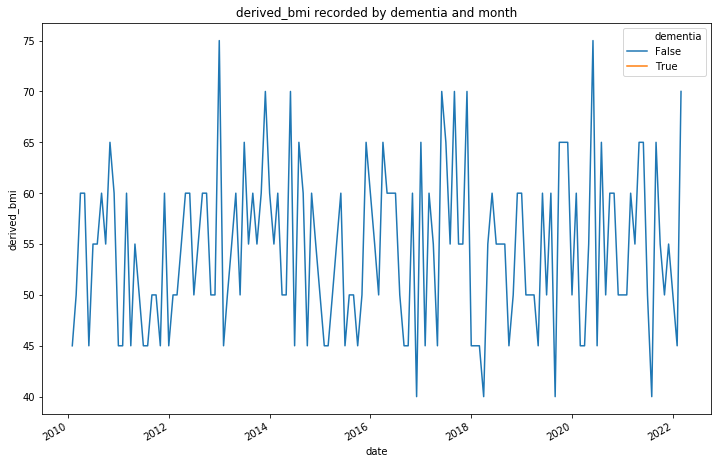

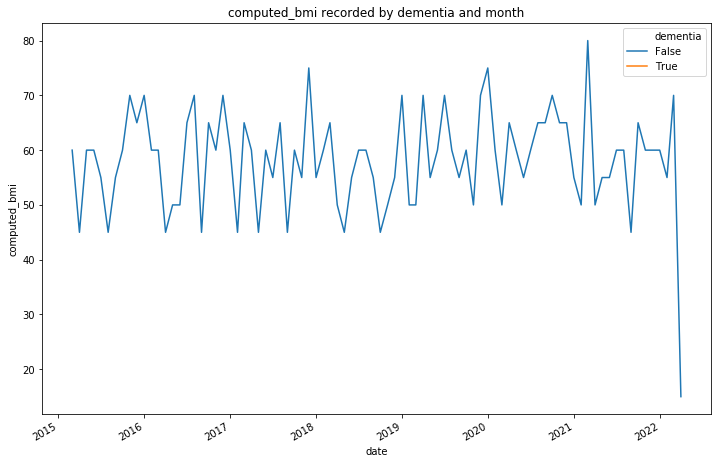

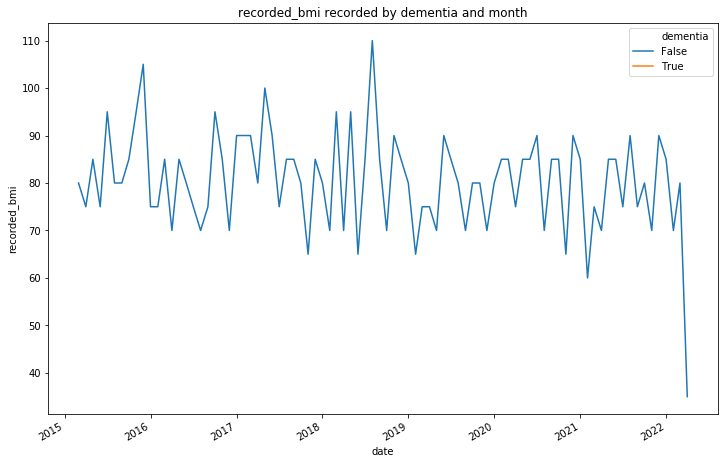

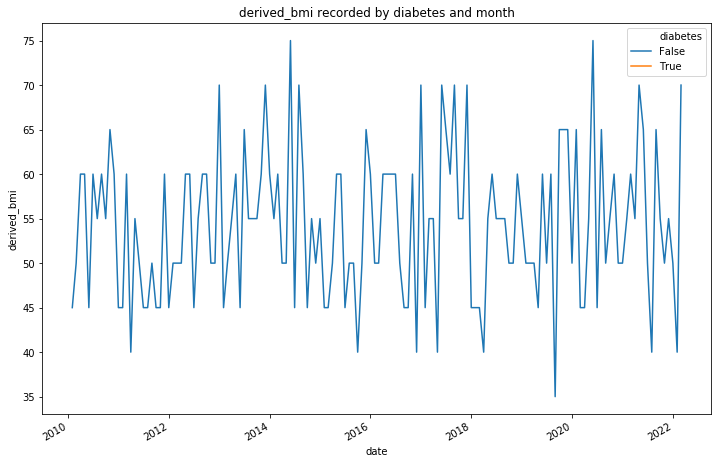

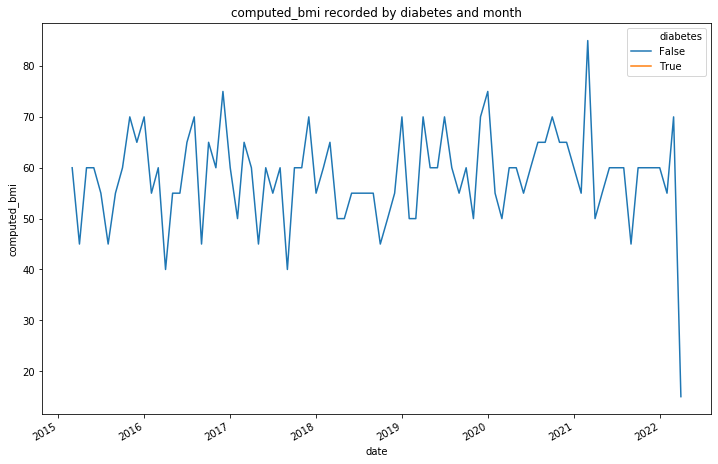

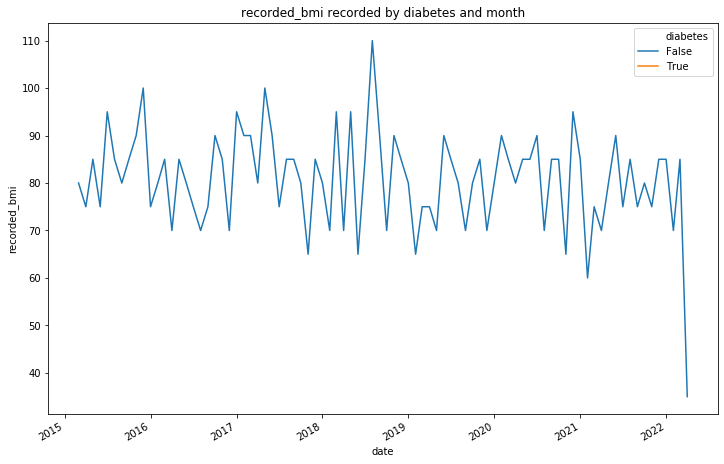

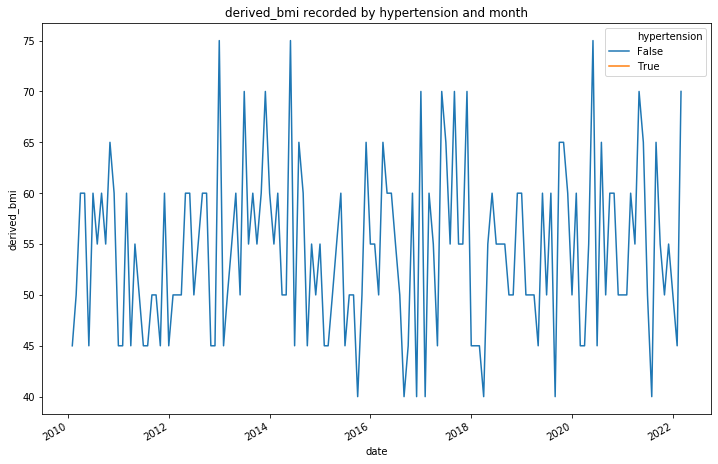

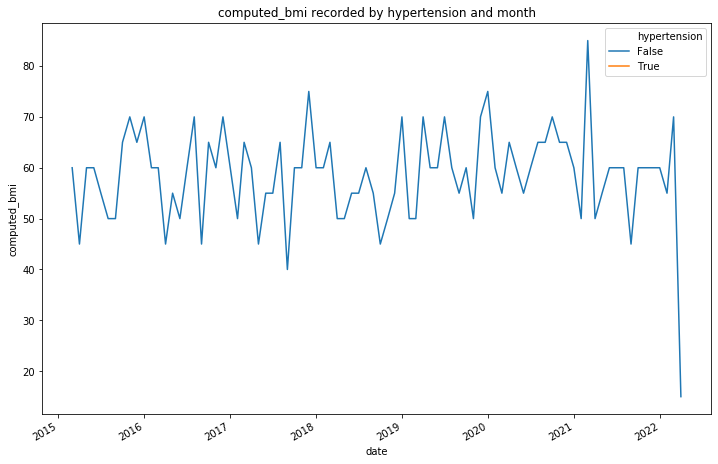

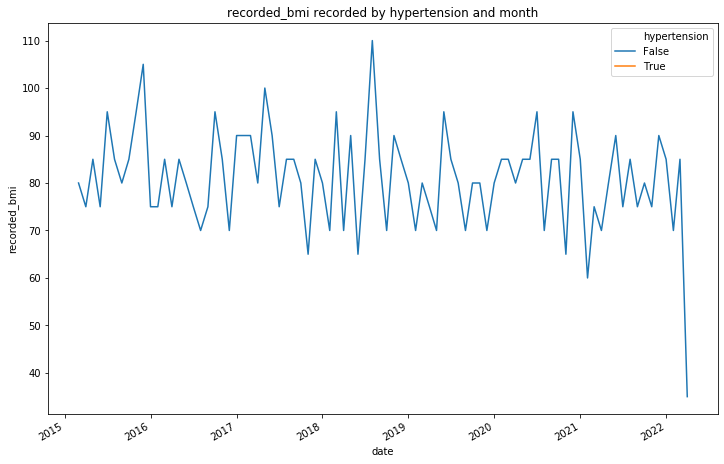

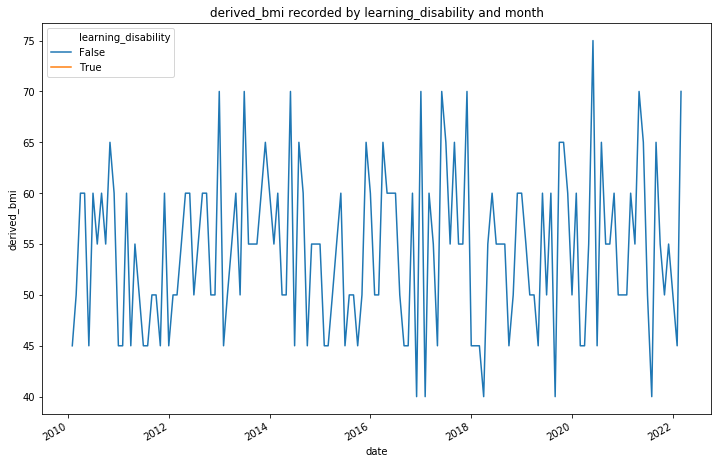

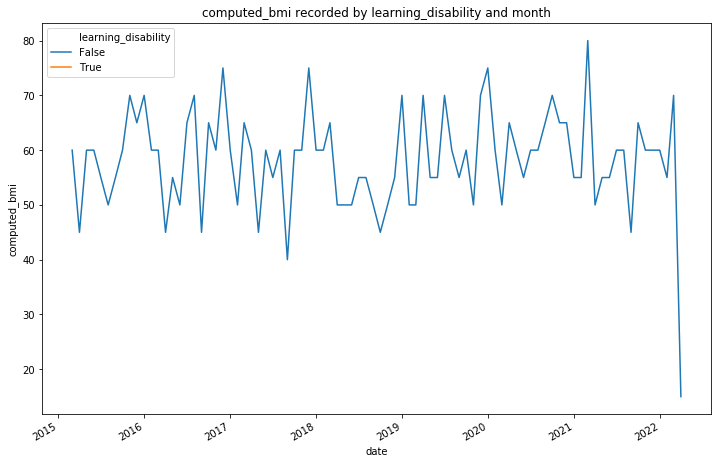

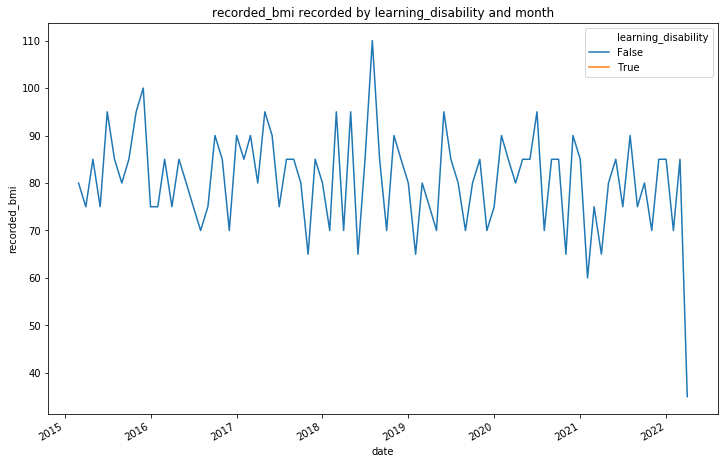

In [7]:
records_over_time(df_clean, definitions, demographic_covariates, clinical_covariates)